In [1]:
import iris
import os
import numpy as np
from mattpy import util as mp
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import iris.coord_categorisation as cc
import pandas as pd

In [7]:
in_dir = '/path/to/mdls
files = [os.path.join(in_dir, file) for file in os.listdir(in_dir)]
cubes = iris.load(files)
for cube in cubes:
    cube.coord('longitude').circular = True

Fix CCSRNIES data which is upside down (lat), borrowing the coordinate from CHASER

In [11]:
print(cubes[0].attributes['model_id'])
cubes[0] = cubes[0][:,:, ::-1]
cubes[0].coord('latitude').attributes = cubes[3].coord('latitude').attributes
cubes[0].coord('latitude').bounds = cubes[3].coord('latitude').bounds

CCSRNIES-MIROC3.2


Fix CMAM bounds

In [12]:
bounds = cubes[4].coord('longitude').bounds.copy()
bounds[-1][-1] = 360.
cubes[4].coord('longitude').bounds = bounds

Remove low top models

In [13]:
mp.remove_mdl_from_cubes(cubes, ['CHASER-MIROC-ESM', 'MOCAGE', 'CESM1-CAM4ChemSD'])

In [14]:
[c.attributes['model_id'] for c in cubes]

['CCSRNIES-MIROC3.2',
 'CESM1-WACCMSD',
 'CMAM',
 'CNRM-CM5-3',
 'CNRM-CM5-3',
 'EMAC-L47MA',
 'EMAC-L47MA',
 'EMAC-L90MA',
 'EMAC-L90MA',
 'GRIMs-CCM',
 'IPSL',
 'MRI-ESM1r1',
 'UMUKCA-UCAM']

Regrid - unfortunately need to do this the slow way :/

In [17]:
def regrid_and_constrain(raw_cubes):
    # This regrids all cubes to the grid specified by a template cube.
    # INPUT
    # raw_cubes (list/iris.cube.CubeList) - The list of cubes to be regridded
    # temp_cube (iris.Cube.cube) - The cube which provides the regridding template
    # OUTPUT (iris.cube.CubeList) - A list of regridded cubes
    
    regridded_cubes = []

    for m in raw_cubes:
        print(m.attributes['model_id'])
        if not m.coord_system() == None:
            m.coord('latitude').coord_system = None
            m.coord('longitude').coord_system = None
        if not m.coord('latitude').has_bounds():
            m.coord('latitude').guess_bounds()
        if not m.coord('longitude').has_bounds():
            m.coord('longitude').guess_bounds()
        scheme = iris.analysis.AreaWeighted(mdtol=0)
        
        # Make 5 degree cube
        n_plev = len(m.coord('air_pressure').points)
        n_lon = len(m.coord('longitude').points)
        
        temp_cube = iris.cube.Cube(np.zeros([n_plev,36,n_lon]))
        lat_coord = iris.coords.DimCoord(np.arange(-87.5, 90, 5), 'latitude', units='degrees')
        lat_coord.guess_bounds()
        lon_coord = m.coord('longitude')
        temp_cube.add_dim_coord(m.coord('air_pressure'), 0)
        temp_cube.add_dim_coord(lat_coord, 1)
        temp_cube.add_dim_coord(lon_coord, 2)

        temp = m.regrid(temp_cube, scheme)      ##### This extrapolate is needed to not add nans in

        regridded_cubes.append(temp)

    return iris.cube.CubeList(regridded_cubes)

In [18]:
regridded_cubes = regrid_and_constrain(cubes)

CCSRNIES-MIROC3.2
CESM1-WACCMSD
CMAM
CNRM-CM5-3
CNRM-CM5-3
EMAC-L47MA
EMAC-L47MA
EMAC-L90MA
EMAC-L90MA
GRIMs-CCM
IPSL
MRI-ESM1r1
UMUKCA-UCAM


Collapse longitude coord

In [19]:
def collapse_lon(in_cube):
    cube = in_cube.collapsed(['longitude'], iris.analysis.MEAN, mdtol=0.5)
    return cube

In [20]:
flat_cubes = [collapse_lon(cube) for cube in regridded_cubes]

Check things are the right way up

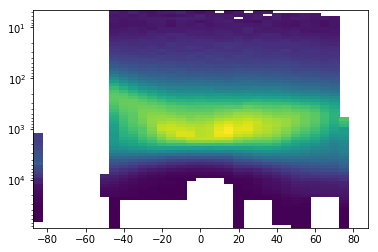

In [25]:
cube = iris.load_cube('/path/to/BSOzone/BSVerticalOzone_MR_PRS_Tier0.0_v1.0.nc', 'ozone_volume_mixing_ratio')
cube.coord('pressure').convert_units('Pa')
plt.figure()
plt.pcolormesh(cube.coord('latitude').points, cube.coord('pressure').points, cube[100].data.T)
plt.yscale('log')
plt.gca().invert_yaxis()
plt.show()

Models are (time, plev, lat) whereas obs are (time, lat plev)

In [26]:
temp_obs = iris.load_cube('/home/amosm1/Analysis/VertOzoneBayNNE/BSVerticalOzone_MR_PRS_Tier0.0_v1.0.nc', 'ozone_volume_mixing_ratio')
temp_obs.coord('pressure').convert_units('Pa')

new_data = np.swapaxes(temp_obs.data,1,2)
new_obs = iris.cube.Cube(new_data, long_name=temp_obs.name(), units=temp_obs.units)
new_obs.attributes = temp_obs.attributes
new_obs.add_dim_coord(temp_obs.coord('time'), 0)
new_obs.add_dim_coord(temp_obs.coord('pressure'), 1)
new_obs.add_dim_coord(temp_obs.coord('latitude'), 2)

### Constrain time to start on Jan1980

In [64]:
con_cubes = []
for cube in flat_cubes:
    if not mp.cube_has_coord(cube, 'year'):
        cc.add_year(cube, 'time')
    if not mp.cube_has_coord(cube, 'month_number'):
        cc.add_month_number(cube, 'time')
    cube = cube.extract(iris.Constraint(year=lambda cell: 1980 <= cell <= 2010))
    con_cubes.append(cube)
    
if not mp.cube_has_coord(new_obs, 'year'):
    cc.add_year(new_obs, 'time')
if not mp.cube_has_coord(new_obs, 'month_number'):
    cc.add_month_number(new_obs, 'time')
new_obs = new_obs.extract(iris.Constraint(year=lambda cell: 1980 <= cell <= 2010))

### Goal is to first set np.nan as any point where the model has no data - down to 8.784e+04 Pa and up to 4.6Pa which is the range of the BDBP product

In [65]:
def pad_cube(cube):
    # Goal is to pad the cube to match the obs (with nans)
    
    min_press = np.min(cube.coord('air_pressure').points)
    max_press = np.max(cube.coord('air_pressure').points)
    
    pidx_min = np.where(np.abs(new_obs.coord('pressure').points - min_press) < 0.001)[0][0]
    pidx_max = np.where(np.abs(new_obs.coord('pressure').points - max_press) < 0.001)[0][0]
    
    time_len = len(cube.coord('time').points)
    print(cube.coord('time')[0])
    
    new_data = mp.nan_array(new_obs.data.shape)
    cube_data = cube.data
    if np.ma.is_masked(cube.data):
        cube.data.fill_value = np.nan
    new_data[:time_len,pidx_max: pidx_min + 1,:] = cube.data.filled()
    
    new_cube = new_obs.copy(new_data)
    new_cube.attributes = cube.attributes
    
    return new_cube
    

In [66]:
padded_cubes = [pad_cube(cube) for cube in con_cubes]

DimCoord([1980-01-16 12:00:00], standard_name='time', calendar='gregorian', long_name='Time', var_name='time', attributes={'actual_range': array([43844.5, 55136.5]), 'bound': 'time_bnds', 'must_have_bounds': 'yes      '})
DimCoord([1980-01-16 12:00:00], bounds=[[1980-01-01 00:00:00, 1980-02-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([1980-01-16 12:00:00], bounds=[[1980-01-01 00:00:00, 1980-02-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([1980-01-16 12:00:00], bounds=[[1980-01-01 00:00:00, 1980-02-01 00:00:00]], standard_name='time', calendar='gregorian', long_name='time', var_name='time')
DimCoord([1980-01-16 12:00:00], bounds=[[1980-01-01 00:00:00, 1980-02-01 00:00:00]], standard_name='time', calendar='gregorian', long_name='time', var_name='time')
DimCoord([1980-01-16 12:00:00], bounds=[[1980-01-01 00:00:00, 1980-02-01 00:00:00]], standard_name='time', calendar='gregorian

## Confirm abs values and units between models and obs 

In [69]:
def flatten_cube(cube, time_coord):
    output = []

    dim_coords = dict()
    for coord in cube.dim_coords:
        dim_coords[coord.name()] = len(coord.points)
    data_len = cube.data.size

    if len(cube.shape) == 3:
        # Then we have time, plev, lat in that order
        lat_data = np.tile(cube.coord('latitude').points, int(
            data_len / dim_coords['latitude'])).reshape(-1,)
        
        plev_data = np.tile(np.repeat(cube.coord(
            'pressure').points, dim_coords['latitude']), dim_coords['time']).reshape(-1,)
        time_data = np.repeat(time_coord.points, int(
            data_len / len(time_coord.points))).reshape(-1,)
        if not mp.cube_has_coord(cube, 'month_number'):
            iris.coord_categorisation.add_month_number(cube, time_coord.name())
        mon_data = np.repeat(cube.coord('month_number').points, int(
            data_len / len(cube.coord('month_number').points))).reshape(-1,)
        year_data = np.repeat(cube.coord('year').points, int(
            data_len / len(time_coord.points))).reshape(-1,)
        
        output = [year_data, time_data, plev_data, lat_data, mon_data]

    return output


def recube(in_array):

    plev_len = 64
    lat_len = 36
    time_len = 30 * 12

    output = np.zeros([time_len, plev_len, lat_len])

    for t in range(time_len):
        output[t,:,:] = in_array[plev_len * lat_len * (t): plev_len * lat_len * (t+1)].reshape([plev_len, lat_len])
    
    return output

In [70]:
for cube in con_cubes:
    mask1 = cube.data < 1e-12
    mask2 = cube.data > 1e-1
    mask3 = np.isnan(cube.data)
    mask = mask1 + mask2 + mask3
    masked_data = np.ma.masked_array(cube.data, mask)
    masked_data.fill_value = np.nan
    cube.data = masked_data

Check mask on obs

In [72]:
data = new_obs.data
mask0 = data.mask
mask1 = data.data < 1e-12
mask2 = data.data > 1e-1
mask = mask0 + mask1 + mask2
data.mask = mask
data.fill_value = np.nan

/home/amosm1/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/home/amosm1/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


# Put into dataframe

In [83]:
# Arrange model data and obs data into a pandas array, which we will use to train the nn
num_vars = 5 # lat, plev, month, months_since, obs
data_shape = (len(padded_cubes) + num_vars, padded_cubes[0].data.size)
model_output = mp.nan_array(data_shape)
mdl_names = []

for i,m in enumerate(padded_cubes):
    if np.ma.is_masked(m.data):
        m_toz = m.data.filled().reshape(-1,)
    else:
        m_toz = m.data.reshape(-1,)
    m_toz[m_toz < 1e-20] = 'nan'
    m_toz[m_toz > 1] = 'nan'
    model_output[i] = m_toz
    mdl_names.append(mp.get_mdls_reals(m))
    
i += 1    
scaled_pandas = model_output

b_obs = new_obs.data.filled().reshape(-1,)

scaled_pandas[i] = b_obs
i += 1  

# Add in all the extra coordinate variables
m_year, m_time, m_plev, m_lat, m_mon = flatten_cube(m, m.coord('time'))

#lat, lon
scaled_pandas[i] = m_plev
i += 1  
scaled_pandas[i] = m_lat
i += 1

# Month
scaled_pandas[i] = m_mon
i+=1

# Add months since start
mon_since = (m_year - 1980) * 12 + m_mon
scaled_pandas[i] = mon_since

input_labels = np.array(mdl_names + ['obs_toz', 'plev', 'lat', 'mon_num', 'mons'])

df_at = pd.DataFrame.from_records(scaled_pandas.T, columns=input_labels)

# Insert has obs - being careful to mask where models don't have preds
# Insert training and testing

/home/amosm1/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/home/amosm1/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


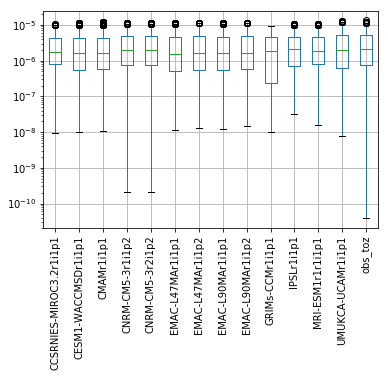

In [84]:
df_at.drop(['plev', 'mons', 'lat', 'mon_num'], axis=1).boxplot()
plt.xticks(rotation='vertical')
plt.yscale('log')

(array([1, 2, 3]), <a list of 3 Text xticklabel objects>)

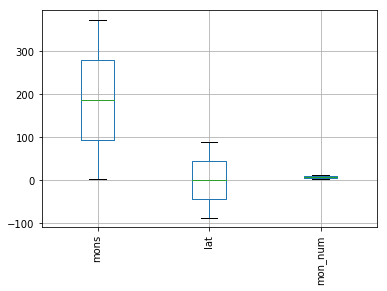

In [85]:
df_at[['mons', 'lat', 'mon_num']].boxplot()
plt.xticks(rotation='vertical')

Set valid for where models and obs have values

In [86]:
df_at['valid'] = np.all(~df_at.isnull().values, axis=1)

Add a temporal extrapolation masks for the last 1.5 years

In [87]:
temp_mask = np.zeros([372, 70, 36])
for i in range(354, 372):
    temp_mask[i] = np.ones([70,36])
temp_mask = np.array(temp_mask, dtype=np.bool)
df_at['temp_extrap'] = np.all([temp_mask.ravel(), df_at['valid'].values], axis=0)

Add a temporal interpolation mask for the middle 1.5 years

In [88]:
temp_mask = np.zeros([372, 70, 36])
for i in range(210, 228):
    temp_mask[i] = np.ones([70,36])
temp_mask = np.array(temp_mask, dtype=np.bool)
df_at['temp_interp'] = np.all([temp_mask.ravel(), df_at['valid'].values], axis=0)

Create training set - 95% - more than 10% is already removed by the temporal validation

In [89]:
train = df_at['valid'].copy()
test = df_at['valid'].copy()
# Excludes last 3 years
for i in range(210 * 70 * 36):
    if train[i] == True:
        new_bool = np.random.uniform() <= 0.95
        train[i] = new_bool
        test[i] = not new_bool
for i in range(210* 70 * 36, 228 * 70 * 36):
    train[i] = False
    test[i] = False
for i in range(228 * 70 * 36, 354 * 70 * 36):
    if train[i] == True:
        new_bool = np.random.uniform() <= 0.95
        train[i] = new_bool
        test[i] = not new_bool
for i in range(354* 70 * 36, 372 * 70 * 36):
    train[i] = False
    test[i] = False
    
df_at['train'] = train
df_at['test'] = test

In [90]:
np.sum(df_at['train'].values)

427718

In [91]:
np.sum(df_at['test'].values)

22551

In [92]:
np.sum(df_at['valid'].values)

514814

In [93]:
np.sum(df_at['temp_extrap'].values)

35484

In [94]:
np.sum(df_at['temp_interp'].values)

29061

In [95]:
100 * 427718 / 514814

83.08204516582688

In [96]:
100 * 22551 / 514814

4.380417004976555

In [97]:
100 * 35484 / 514814

6.892586448697976

In [98]:
100 * 29061 / 514814

5.644951380498588

In [99]:
5.6 + 6.9 + 4.4 + 83.1

100.0

In [100]:
df_at.to_pickle('/home/amosm1/Analysis/VertOzoneBayNNE/vmro3_refC1SD_70x36_13mdls_masked_extrap_and_interp.pkl', protocol=4)

In [75]:
df_at

,CCSRNIES-MIROC3.2r1i1p1,CESM1-CAM4ChemSDr1i1p1,CESM1-WACCMSDr1i1p1,CHASER-MIROC-ESMr1i1p1,CMAMr1i1p1,CNRM-CM5-3r1i1p2,CNRM-CM5-3r2i1p2,EMAC-L47MAr1i1p1,EMAC-L47MAr1i1p2,EMAC-L90MAr1i1p1,...,plev,lat,mon_num,mons,valid,temp_valid,temp_interp,train,test,temp_extrap
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,87836.403192,-87.5,1.0,1.0,False,False,False,False,False,False
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,87836.403192,-82.5,1.0,1.0,False,False,False,False,False,False
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,87836.403192,-77.5,1.0,1.0,False,False,False,False,False,False
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,87836.403192,-72.5,1.0,1.0,False,False,False,False,False,False
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,87836.403192,-67.5,1.0,1.0,False,False,False,False,False,False
5,1.976584e-08,1.115565e-08,1.142264e-08,1.214127e-08,1.252028e-08,0.0,0.0,1.284931e-08,1.560909e-08,1.337558e-08,...,87836.403192,-62.5,1.0,1.0,False,False,False,False,False,False
6,1.977397e-08,1.135714e-08,1.158126e-08,1.222270e-08,1.310658e-08,0.0,0.0,1.326393e-08,1.617136e-08,1.373874e-08,...,87836.403192,-57.5,1.0,1.0,False,False,False,False,False,False
7,1.934452e-08,1.211324e-08,1.233347e-08,1.272078e-08,1.413050e-08,0.0,0.0,1.411759e-08,1.725326e-08,1.451562e-08,...,87836.403192,-52.5,1.0,1.0,False,False,False,False,False,False
8,1.811029e-08,1.340466e-08,1.362756e-08,1.374691e-08,1.542229e-08,0.0,0.0,1.547331e-08,1.884702e-08,1.571102e-08,...,87836.403192,-47.5,1.0,1.0,False,False,False,False,False,False
9,1.665047e-08,1.495703e-08,1.513734e-08,1.516025e-08,1.707455e-08,0.0,0.0,1.706185e-08,2.058884e-08,1.711339e-08,...,87836.403192,-42.5,1.0,1.0,False,False,False,False,False,False
